In [1]:
#!pip install wordcloud
#!pip install pandas_profiling
#!pip install imbalanced-learn
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import nltk # NLP
import matplotlib.pyplot as plt
from wordcloud import WordCloud # NL
import string
from nltk.corpus import stopwords
import time
import copy
#Models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV,train_test_split,KFold,StratifiedKFold,cross_val_score,learning_curve
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from scipy.sparse import hstack # Concat multiple vectors?

# NLP
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Goodie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Goodie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocessing 

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_train.columns = ['id', 'job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements','benefits','telecommuting', 'logo', 'questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'doughnuts' , 'fraudulent']
df_test.columns = ['id', 'job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements','benefits','telecommuting', 'logo', 'questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'doughnuts']

In [3]:
# FAST ANALYSIS OF DATA

# profile = ProfileReport(train_df, title="Pandas Profiling Report TRAIN")
# profile.to_file("train.html")
# profile = ProfileReport(train_df.loc[train_df.fraudulent==1], title="Pandas Profiling Report FRAUDULENT TRAIN")
# profile.to_file("fraud_train.html")

### Clean NaN  

#### TRAIN 

In [4]:
#First we delete rows where the target is nan.
df_train = df_train.dropna(how='any',subset=["fraudulent"],axis=0)


df_train = df_train.drop(["id", "doughnuts"], axis=1)

In [5]:
# We save a dataframe with all the fraudulent values.
subset_frau = df_train[df_train['fraudulent'] == 1]
df_train = df_train.drop(subset_frau.index,axis= 0) 

In [6]:
df_train=df_train.dropna(axis=0, thresh=8)
#df_train=df_train.dropna(axis=1, thresh=0.35*df_train.shape[0])
df_train=df_train.drop(["salary_range"], axis=1)
np.setdiff1d(subset_frau.columns, df_train.columns) # What columns have we deleted?

array(['salary_range'], dtype=object)

In [7]:
print(df_train.shape)

(10233, 17)


In [8]:
subset_frau=subset_frau.drop(["salary_range"], axis=1)
df_train=pd.concat([df_train, subset_frau])
print(f'Shape of Nan processed train DF {df_train.shape}')
df_train.sample(3)

Shape of Nan processed train DF (10727, 17)


,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,logo,questions,employment_type,required_experience,required_education,industry,function,fraudulent
9850,12393,Finance Manager (India),"IN, HR, Gurgaon",Operations,"As augmented reality jobs go, one at Blippar i...","We are looking for an energetic, efficient and...",We are looking for a candidate with a strong a...,NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Accounting,Accounting/Auditing,0
7321,10982,Hemel Heampstead Business Admin Apprenticeship...,"GB, , Hemel Hempstead",NaN,Established on the principles that full time e...,Government FUNDING is only available for 16-18...,16-18 year olds only due to government funding...,Career prospects.,0,1,1,Full-time,Not Applicable,High School or equivalent,NaN,Administrative,0
8640,38,PROJECT MANAGER,"US, TX, HOUSTON",NaN,NaN,we are looking for a Project Manager. The Proj...,NaN,NaN,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Oil & Energy,Engineering,0


In [9]:
# NaN for Unkown {category}
for (columnName, columnData) in df_train.iteritems():
    name="Unknown {}".format(columnName)
    df_train[columnName] = df_train[columnName].replace(np.nan,name)
df_train.sample(3)

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,logo,questions,employment_type,required_experience,required_education,industry,function,fraudulent
3400,4608,CALL CENTER REP,"US, TX, DALLAS",CALLCENTER,The Accion story began more than 100 years ag...,Our Call Center Rep would be expected to be ex...,The qualifications for this position ensure yo...,"100% coverage of dental, vision and life insur...",0,1,1,Full-time,Associate,High School or equivalent,Financial Services,Customer Service,1
506,6175,Backend JavaScript developer,"DE, BE, Berlin",Development,Unknown company_profile,Contentful (#URL_0252efddcbc4b8f51969fca7b0545...,Solid experience writing maintainable and well...,The Web is changing and becoming more interact...,0,1,1,Full-time,Mid-Senior level,Unknown required_education,Internet,Information Technology,0
9117,10607,Sr. Vice President - Global & Strategic Accounts,"US, OH, Mason",GSA,"About Us:For nearly 20 years, Touchstone has b...",SVP – GLOBAL &amp; STRATEGIC ACCOUNTSPosition ...,Requirements:10 Years Promotional Products Glo...,"Salary Range:$125,000 range (Salary will be co...",0,1,0,Full-time,Executive,Bachelor's Degree,Marketing and Advertising,Management,0


#### TEST 

In [10]:
#job_id
df_test=df_test.drop(["id", "doughnuts"], axis=1)
df_test=df_test.drop(["salary_range"], axis=1)

for (columnName, columnData) in df_test.iteritems():
    name="Unknown {}".format(columnName)
    df_test[columnName] = df_test[columnName].replace(np.nan,name)

#### Splitting location in 3 new features.

In [11]:
def get_country(row):
    spl = row['location'].split(',')
    return spl[0]

def get_region(row):
    spl = row['location'].split(',')
    if len(spl) >= 2:
        return spl[1]
    else:
        return 'Unknown'

def get_city(row):
    spl = row['location'].split(',')
    if len(spl) >= 3:
        return spl[2]
    else:
        return 'Unknown'

In [12]:
df_train['country'] = df_train.apply(get_country, axis=1)
df_train['region'] = df_train.apply(get_region, axis=1)
df_train['city'] = df_train.apply(get_city, axis=1)
df_train=df_train.drop("location", axis=1)

In [13]:
df_test['country'] = df_test.apply(get_country, axis=1)
df_test['region'] = df_test.apply(get_region, axis=1)
df_test['city'] = df_test.apply(get_city, axis=1)
df_test=df_test.drop("location", axis=1)

## Text Analysis 

We first need to process our text to eliminate commas, points and all this useless stuff for our model!

In [14]:
def text_process(text, lower=False):
    """text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
        translated any punctuation within text to whitespace, so using replace(' '*4, ' ') 
        is to replace 4 consecutive whitespace to single one, replace(' '*3, ' ')
        from 3 to 1, and so on; then strip to eliminate the whitespaces before & after.

     NECESSARY TO DO THINGS LIKE: Requirements/Qualifications:1 year -> Requirements Qualification 1 year 
    """
    text = text.translate(
    str.maketrans(string.punctuation, ' ' * len(string.punctuation))).replace(
    ' '*4, ' ').replace(' '*3, ' ').replace(' '*2, ' ').strip()
    # Eliminates the stopwords useless for our model
    if lower:
        text = [word.lower() for word in text.split() if word.lower() not in stopwords.words('english')]
    else:
        text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

In [15]:
def wordcloud(df, size=(10,7)):
    """
    Computes the WordCloud of a column of dataframe or saying it in another way, of text values.
    """
    titles_ls = [text for text in df]
    real_all_words = ' '.join(df)
    wordcloud_real = WordCloud(background_color='white',
        width= 800, height= 500,
        max_font_size = 180,
        collocations = False).generate(real_all_words)

    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud_real

Let's process for the train and test data!

In [16]:
start = time.time()
df_train_proc = pd.DataFrame()
cols = ['title', 'country', 'region', 'city', 'department','company_profile', 'description', 'requirements', 
            'benefits', 'industry', 'function','employment_type','required_experience','required_education']
for col in cols:
    df_train_proc[col] = df_train[col].apply(text_process)
    print(f'{col} processed.')
end = time.time()
print(f'{end-start} seconds to compute {cols}')

start = time.time()
df_test_proc = pd.DataFrame()
cols = ['title', 'country', 'region', 'city', 'department', 'company_profile', 'description', 'requirements', 
            'benefits', 'industry', 'function','employment_type','required_experience','required_education']
for col in cols:
    df_test_proc[col] = df_test[col].apply(text_process)
    print(f'{col} processed.')
end = time.time()
print(f'{end-start} seconds to compute {cols}')


title processed.
country processed.
region processed.
city processed.
department processed.
company_profile processed.
description processed.
requirements processed.
benefits processed.
industry processed.
function processed.
employment_type processed.
required_experience processed.
required_education processed.
1042.9544923305511 seconds to compute ['title', 'country', 'region', 'city', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'industry', 'function', 'employment_type', 'required_experience', 'required_education']
title processed.
country processed.
region processed.
city processed.
department processed.
company_profile processed.
description processed.
requirements processed.
benefits processed.
industry processed.
function processed.
employment_type processed.
required_experience processed.
required_education processed.
667.6662411689758 seconds to compute ['title', 'country', 'region', 'city', 'department', 'company_profile', 'description', 'requir

OSError: Cannot save file into a non-existent directory: '\csv text'

In [19]:
df_train_proc.shape, df_test_proc.shape

((10727, 14), (7152, 14))

In [20]:
df_train_proc.to_csv('TRAIN_processed.csv')
df_test_proc.to_csv('TEST_processed.csv')

### Features to vectorize 

In [75]:
selected_cols = ['title', 'city', 'department', 'company_profile', 'requirements', 
            'benefits', 'industry', 'function','employment_type','required_experience','required_education']
df_train_selected = df_train_proc[selected_cols]
X = df_train_selected
y = df_train.fraudulent
#X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3, random_state=42)

In [76]:
# How many Unkown for col
for col in selected_cols:
    name = f'Unknown {col}'
    print(f'{col} / Unknown: {df_train[df_train[col]==name].shape[0]}', df_train[col].shape[0] )

title / Unknown: 0 10727
city / Unknown: 0 10727
department / Unknown: 7008 10727
company_profile / Unknown: 1961 10727
requirements / Unknown: 1628 10727
benefits / Unknown: 4367 10727
industry / Unknown: 2938 10727
function / Unknown: 3869 10727
employment_type / Unknown: 2057 10727
required_experience / Unknown: 4238 10727
required_education / Unknown: 4900 10727


### Vectorize  

In [77]:
def vectorize_df(df, fit=False, vectorizer_cols=None, max_features=0, ngram_range=(1,1)):
    vector_cols = {} # Create a dict with all columns vectors stored in its matrixes
    if fit: vectorizer_cols = {} # Vectorizer learns from one column only. MUST DO IT one by one. FIT PHASE.
    
    for col in df.columns:
        if fit:
#             print('Fitting and Transforming')
            vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
            vectors_col = vectorizer.fit_transform(df[col])
            vectorizer_cols[col] = vectorizer # Store the specific vectorizer.
        else:
#             print('Transforming')
            vectors_col = vectorizer_cols[col].transform(df[col]) # Transform with the vectorizer which we've learnt.
            
        vector_cols[col] = vectors_col
        
    # Stack together all matrixes in one.
#     try:
#         del vectors
#     except:
#         print('Deleted past vectors')
    for i, col in enumerate(vector_cols.keys()):
        if i==0:
            vectors = hstack([vector_cols[col], vector_cols[list(vector_cols.keys())[i+1]]]) # Stack first and second
        else:
            try:
                vectors = hstack([vectors, vector_cols[list(vector_cols.keys())[i+1]]]) # Stack the previous stack with next el.
            except Exception as e:
#                 print(col, i, e) # Out of Range, lazy to put another if
                break
    return vectors, vectorizer_cols

We will try it with a few columns first, the ones we've seen have the more correlation and might better behaviour! These features are:
* Title
* Industry 1:(Oil/Energy/Accounting)
* Function 1:(Administrative) ; 0:(Information/Tech)
* Dept 1:(Clerical, Engineering)
* Company Profile: (Service/Candidate) !Be careful with Unkwnown here!


In [78]:
train_vectors, vectorizer = vectorize_df(X, fit=True)

In [79]:
train_vectors.shape

(10727, 69886)

In [80]:
df_bool = df_train[['telecommuting','logo','questions']]
X_bool = df_bool.values

# X_id = df_train['job_id'].values
# X_id = X_id.reshape(-1,1)
# X_id = X_id.astype(int)
# X = hstack((train_vectors,X_bool,X_id))

X = hstack((train_vectors,X_bool))

## Modeling

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3, random_state=42)
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# clf = XGBClassifier(max_depth=9,min_child_weight=2)
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
gsc = GridSearchCV(
            estimator=XGBClassifier(random_state=42),
            param_grid={"learning_rate": [0.15],
                        "max_depth": [ 6, 9],
                        "min_child_weight": [1]},
            cv=5, scoring='f1', verbose=0, n_jobs=-1)
gsc.fit(X_train, y_train)
# clf.fit(X_train, y_train, classes_weights)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [83]:
gsc.best_params_

{'learning_rate': 0.15, 'max_depth': 9, 'min_child_weight': 1}

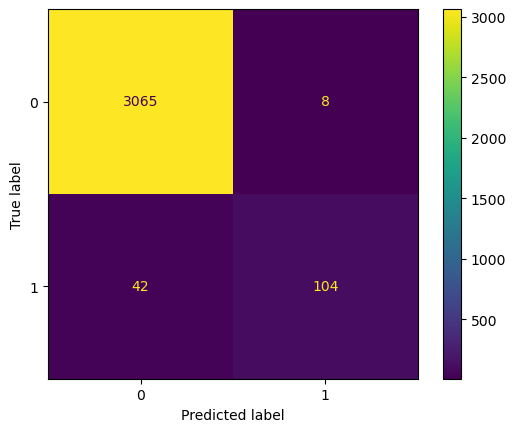

In [84]:
ConfusionMatrixDisplay.from_estimator(gsc, X_valid, y_valid)

In [85]:
f1_score(y_valid, gsc.predict(X_valid))

0.8062015503875969

In [58]:
X.shape, y.shape

((10727, 935582), (10727,))

In [74]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
X_embedded_PCA = PCA(n_components=5000).fit_transform(X)
X_embedded_tsne = TSNE(n_components=2).fit_transform(X_embedded_PCA)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [47]:
#To predict test.csv we train the model with the complete dataset.
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

clf = XGBClassifier(max_depth=9,min_child_weight=2)
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y
)
clf.fit(X, y,classes_weights)

C:\Users\Goodie\anaconda3\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

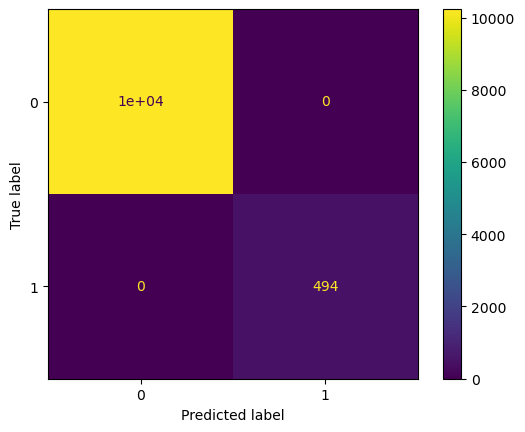

In [48]:
ConfusionMatrixDisplay.from_estimator(clf, X, y)

In [49]:
f1_score(y, clf.predict(X))

1.0

### PREPARE TEST 

In [ ]:
X_test = df_test_proc[selected_cols]

In [ ]:
test_vectors, _ = vectorize_df(X_test, fit=False, vectorizer_cols=vectorizer)

In [ ]:
test_vectors.shape, X_test.shape

In [ ]:
df_bool = df_test[['telecommuting','logo','questions']]
X_bool = df_bool.values

X_id = df_test['job_id'].values
X_id = X_id.reshape(-1,1)
X_id = X_id.astype(int)

X_test = hstack((test_vectors,X_bool,X_id))

X_test = scaler.transform(X_test)

In [ ]:
yhat = clf.predict(X_test)
#Saving the prediction in the Kaggle format.
d = {'Id': range(len(yhat)), 'Category': yhat.astype(int)}
df = pd.DataFrame(data=d)
df.to_csv('submission.csv',index=False)